In [1]:
import torch
from diffusers import AutoPipelineForText2Image
import matplotlib.pyplot as plt
import os

/home/solarspaceclouds/Desktop/lora/lora/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/solarspaceclouds/Desktop/lora/lora/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Initialize the pipeline with Stable Diffusion model
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

# Define parameters for image generation
text_prompt = "a green pokemon with blue eyes"
seed = 3 # for reproducibility
num_imgs = 1
h, w = 512, 512
num_inference_steps = 15
guidance_scale = 7.5



Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


In [3]:
# Define a function to save images
def save_image(image, filename):
    image.save(f"{filename}.png")
    print(f"Image saved as {filename}.png")


# Function to generate and save an image
def generate_and_save_image(prompt, lora_weights=None, lora_scale=None, tag=""):
    pipeline.unfuse_lora()  # Clean up for the next generation
    pipeline.unload_lora_weights()  # Ensure no weights are loaded for next run

    generator = torch.Generator(device="cuda").manual_seed(seed)
    if lora_weights:
        pipeline.unfuse_lora()  # Reset previous LoRAs if any
        for weight, scale in zip(lora_weights, lora_scale):
            pipeline.load_lora_weights(weight, weight_name=weight.split("/")[-1])
            pipeline.fuse_lora(lora_scale=scale)
    
    image = pipeline(prompt + tag, generator=generator, num_inference_steps=num_inference_steps, 
                     guidance_scale=guidance_scale, height=h, width=w, 
                     num_images_per_prompt=num_imgs).images[0]
    folder_name = prompt.replace(" ","_")
    folder_path = os.path.join("generated_images", folder_name)
    print(folder_path)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    plt.imshow(image)
    save_image(image, f"{folder_path}/{tag if tag else 'basic'}")
    

# Stable Diffusion Model only

100%|██████████| 15/15 [00:02<00:00,  6.98it/s]


generated_images/a_green_pokemon_with_blue_eyes
Image saved as generated_images/a_green_pokemon_with_blue_eyes/basic.png


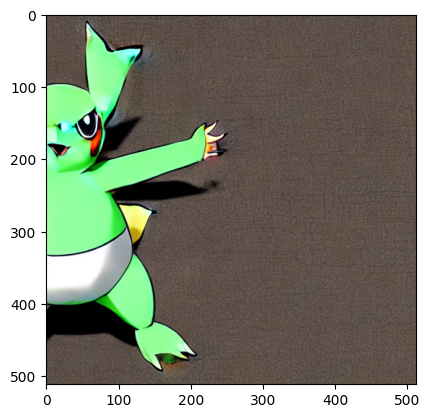

In [4]:
# Generate base model image
generate_and_save_image(text_prompt, tag="basic")

# Single LoRA
- easter egg LoRA, easter egg LoRA with easter egg tag included in text prompt
- jellyfish forest LoRA, jellyfish forest LoRA with jellyfish forest tag included in text prompt
- pixel LoRA, pixel LoRA with pixel tag included in text prompt
- wanostyle LoRA, wanostyle LoRA with wanostyle tag included in text prompt

100%|██████████| 15/15 [00:01<00:00,  8.28it/s]


generated_images/a_green_pokemon_with_blue_eyes
Image saved as generated_images/a_green_pokemon_with_blue_eyes/easter.png


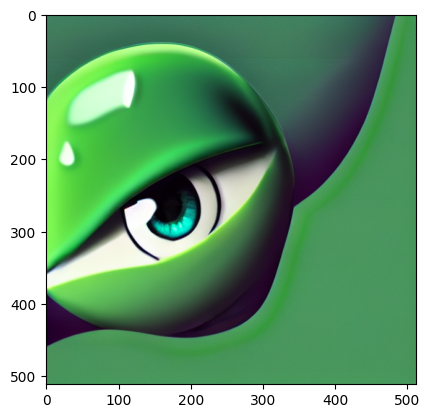

In [5]:
# Apply Single LoRA: Easter Egg with easter egg tag
generate_and_save_image(text_prompt,
                        lora_weights=["./LoRAs/easter-fusion-v2.safetensors"], 
                        lora_scale=[0.7], 
                        tag = "easter")

100%|██████████| 15/15 [00:01<00:00,  8.29it/s]


generated_images/a_green_pokemon_with_blue_eyes
Image saved as generated_images/a_green_pokemon_with_blue_eyes/jellyfishforest.png


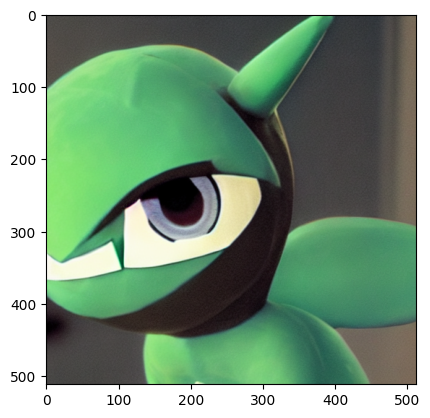

In [6]:
# Apply Single LoRA: Jellyfish Forest
generate_and_save_image(text_prompt, 
                        lora_weights=["./LoRAs/jellyfish-forest.safetensors"], 
                        lora_scale=[0.7], 
                        tag="jellyfishforest")

100%|██████████| 15/15 [00:01<00:00,  8.27it/s]


generated_images/a_green_pokemon_with_blue_eyes
Image saved as generated_images/a_green_pokemon_with_blue_eyes/basepixel.png


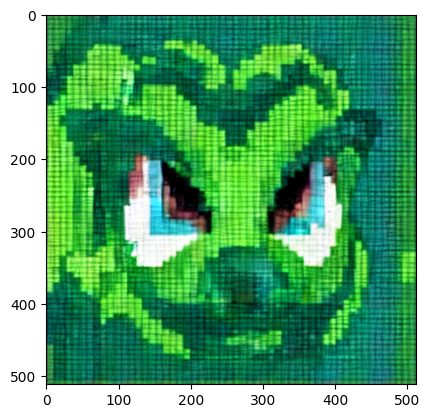

In [7]:
# Apply Single LoRA: Pixel 
generate_and_save_image(text_prompt, 
                        lora_weights=["./LoRAs/basepixel-20.safetensors"], 
                        lora_scale=[0.7], 
                        tag="basepixel")

100%|██████████| 15/15 [00:01<00:00,  8.16it/s]


generated_images/a_green_pokemon_with_blue_eyes
Image saved as generated_images/a_green_pokemon_with_blue_eyes/wanostyle.png


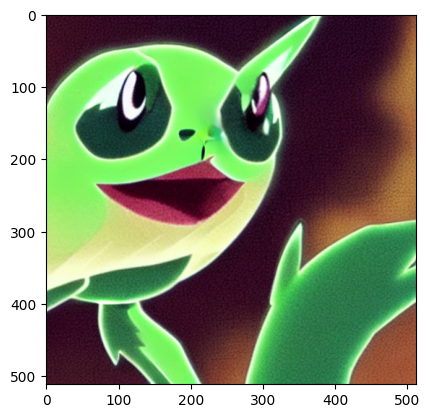

In [8]:
# Apply Single LoRA: Wanostyle 
generate_and_save_image(text_prompt, 
                        lora_weights=["./LoRAs/wanostyle_2_offset.safetensors"], 
                        lora_scale=[0.7], 
                        tag="wanostyle")

# Single LoRAs Results Reflections
- In general, generated image results are better (more closely follow the LoRA) when the specific LoRA tag is included in the text prompt. 
    - Hence, the following section which applies Multiple LoRAs to the Stable Diffusion model will only explore the use of LoRAs WITH the respective LoRA tags.
    
- fuse_loRA method's lora_scale parameter value >0.5 yields generally better results than values <=0.5
- For LoRA types such as concept LoRA (jellyfish forest), which are not very suitable for the text prompt subject matter "a green pokemon with blue eyes" is an object, results are generally poor

## Apply Multiple LoRAs
- all prompts in this section include the relevant tags of the respective LoRAs

/home/solarspaceclouds/Desktop/lora/lora/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:657: UserWarning: All adapters are already merged, nothing to do.
  warnings.warn("All adapters are already merged, nothing to do.")
100%|██████████| 15/15 [00:01<00:00,  8.09it/s]


generated_images/a_green_pokemon_with_blue_eyes
Image saved as generated_images/a_green_pokemon_with_blue_eyes/easter basepixel.png


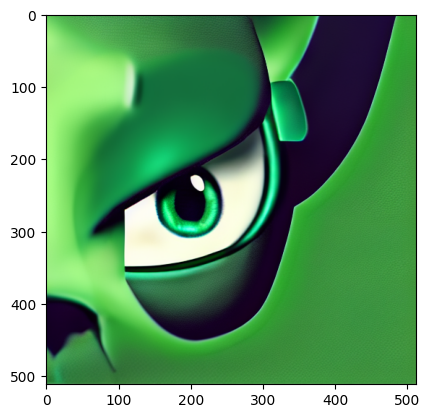

In [9]:
# Apply Multiple LoRAs: Easter + Pixel
generate_and_save_image(text_prompt, 
                        lora_weights=["./LoRAs/easter-fusion-v2.safetensors", "./LoRAs/basepixel-20.safetensors"], 
                        lora_scale=[0.7, 1.0], 
                        tag="easter basepixel")

100%|██████████| 15/15 [00:01<00:00,  8.07it/s]


generated_images/a_green_pokemon_with_blue_eyes
Image saved as generated_images/a_green_pokemon_with_blue_eyes/easter jellyfishforest.png


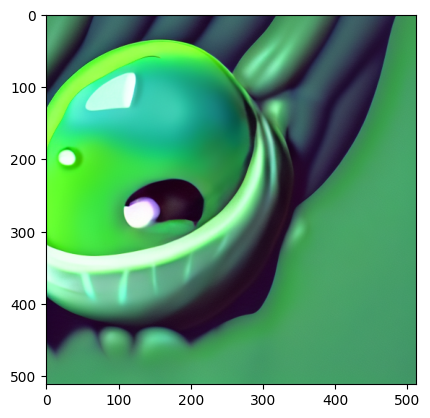

In [10]:
# Apply Multiple LoRAs: Easter + Jellyfish Forest
generate_and_save_image(text_prompt, 
                        lora_weights=["./LoRAs/easter-fusion-v2.safetensors", "./LoRAs/jellyfish-forest.safetensors"], 
                        lora_scale=[0.7, 1.0], 
                        tag="easter jellyfishforest")

100%|██████████| 15/15 [00:01<00:00,  8.06it/s]


generated_images/a_green_pokemon_with_blue_eyes
Image saved as generated_images/a_green_pokemon_with_blue_eyes/wanostyle basepixel.png


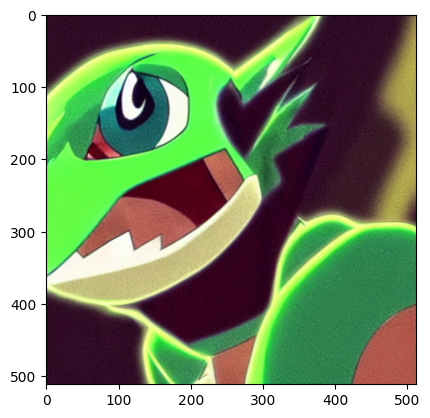

: 

In [11]:
# Apply Multiple LoRAs: Wanostyle + Pixel
generate_and_save_image(text_prompt, 
                        lora_weights=["./LoRAs/wanostyle_2_offset.safetensors", "./LoRAs/basepixel-20.safetensors"], 
                        lora_scale=[0.8, 1], 
                        tag="wanostyle basepixel")

# Multiple LoRAs Results Reflections

Results from merging multiple LoRAs tend to be unpredictable/bizarre for an object text prompt.
This could be due to
- uncomplementary LoRAs styles/concepts/objects/etc.
- suitability of num_inference_steps and guidance scale
  - optimal num_inference_steps and guidance scale can be determined empirically (trial and error)